In [1]:
using PyPlot
using Distributions
using Interact
using LinearAlgebra

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-8741575891379969979\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-6807615071516335653\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio/main\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n        console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n        warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-8741575891379969979\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

# Gaussian Processes

In [2]:
function meanVector(X, m::Function)
    n = size(X,2)
    mu = zeros(n)
    for i = 1:n
        mu[i] = m(X[:,i])
    end
    return mu
end;

In [3]:
zeroMean() = x -> 0.;

There are many kinds of kernel functions:  
Constant: $\sigma_0^2$  
Linear: $\sum_{d=1}^D \sigma_d^2 x_d x'd$  
Polynomial: $(x^\top x' + \sigma_0^2)^p$  
Squared exponential: $\exp(-\frac{r^2}{2\ell^2})$  
Matern: $\frac{1}{2^{\nu-1}\Gamma(\nu)}\left(\frac{\sqrt{2\nu}}{\ell}r\right)^\nu K_\nu\left(\frac{\sqrt{2\nu}}{\ell}r \right)$  
Exponential: $\exp(-\frac{r}{\ell})$  
$\gamma$-exponential: $\exp(-\frac{r}{\ell})$  
Rational quadratic: $(1 + \frac{r^2}{2\alpha\ell^2})^{-\alpha}$  
Neural network: $\sin^{-1}\left(\frac{2\bar x^\top \Sigma \bar x'}{\sqrt{(1+2\bar x^\top \Sigma \bar x)(1+2\bar x'^\top \Sigma \bar x')}} \right)$ where $\bar x$ is the augmented input vector $[1, x_1, \ldots, x_d]$  
see Table 4.1 in http://www.gaussianprocess.org/gpml/chapters/RW4.pdf 

In [4]:
function covMatrix(X, Y, k::Function)
    n = size(X,2)
    m = size(Y,2)
    Σ = zeros(n, m)
    for i = 1:n
        for j = 1:m
            Σ[i,j] = k(X[:,i], Y[:,j])
        end
    end
    Σ
end;

In [5]:
# add a little inflation to avoid numerical issues (non-PSD)
mvnrand(μ, Σ, inflation = 1e-6) = rand(MvNormal(μ, Σ + inflation .* I));

In [6]:
squaredExponential(xi, xj, ℓ = 1) = exp(-(norm(xi - xj)/ℓ)^2);

In [7]:
squaredExponential(ℓ = 1) = (xi,xj) -> squaredExponential(xi, xj, ℓ);

In [8]:
function sampleGP(X, m::Function, k::Function)
    Σ = covMatrix(X, X, k)
    μ = meanVector(X, m)
    Y = mvnrand(μ, Σ)
end;

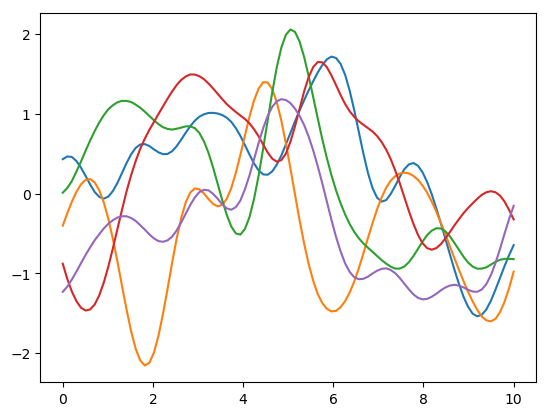

In [9]:
X = range(0,stop=10,length=100)'
for i = 1:5
    Y = sampleGP(X, zeroMean(), squaredExponential())
    plot(dropdims(X,dims=1), Y)
end

In [10]:
# Examples of different characteristic length scales
fig = figure()
@manipulate for ℓ in [0.01, 0.1, 1., 5., 10., 20.]
    withfig(fig) do
        for j = 1:5
            Y = sampleGP(X, zeroMean(), squaredExponential(ℓ))
            plot(dropdims(X,dims=1), Y)  
            title("Charateristic length scale=$ℓ")
        end
    end
end

┌ Warning: Accessing `scope.id` is deprecated, use `scopeid(scope)` instead.
│   caller = ip:0x0
└ @ Core :-1


Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Scope(Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["ℓ"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")))], Dict{Symbol,Any}(:className=>"interact-flex-row-left")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>6,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()))], Dict{Symbol,Any}(:className=>"interact-flex-row-center")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_val")))], Dict{Symbol,Any}(:className=>"interact-flex-row-right"))], Dict{Symbol,Any}(:className=>"interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"index"=>(Observable{Any} with 2 listeners. Value:
3, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\Mykel\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\Mykel\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\Mykel\\.julia\\packages\\InteractBase\\l8cEC\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\Mykel\\.julia\\packages\\InteractBase\\l8cEC\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\Mykel\\.julia\\packages\\Interact\\0klKX\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes"=>Any[JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index"=>Any[JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Channel{AbstractConnection}(sz_max:32,sz_curr:0)), WebIO.JSString[JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.01\",\"0.1\",\"1.0\",\"5.0\",\"10.0\",\"20.0\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"8165917221002872837\",\"id\":\"ob_03\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"8165917221002872837\",\"id\":\"ob_02\",\"type\":\"observable\"})};\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.obse

In [11]:
function meshgrid(vx::AbstractVector, vy::AbstractVector)
    m, n = length(vy), length(vx)
    vx = reshape(vx, 1, n)
    vy = reshape(vy, m, 1)
    (repeat(vx, m, 1), repeat(vy, 1, n))
end

meshgrid (generic function with 1 method)

In [12]:
# 2D Gaussian Process
fig = figure()
@manipulate for ℓ in [0.1, 1., 5., 10.]
    withfig(fig) do
        (x,y) = meshgrid(range(0,stop=10,length=40), range(0,stop=10,length=40))
        X = [x[:]'; y[:]']
        Y = sampleGP(X, zeroMean(), squaredExponential(ℓ))
        contour(x,y,reshape(Y,size(x)));
        title("Charateristic length scale=$ℓ")
    end
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Scope(Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["ℓ"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")))], Dict{Symbol,Any}(:className=>"interact-flex-row-left")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>4,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()))], Dict{Symbol,Any}(:className=>"interact-flex-row-center")), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_val")))], Dict{Symbol,Any}(:className=>"interact-flex-row-right"))], Dict{Symbol,Any}(:className=>"interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"index"=>(Observable{Any} with 2 listeners. Value:
2, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\Mykel\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\Mykel\\.julia\\packages\\Knockout\\1sDlc\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\Mykel\\.julia\\packages\\InteractBase\\l8cEC\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\Mykel\\.julia\\packages\\InteractBase\\l8cEC\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\Mykel\\.julia\\packages\\Interact\\0klKX\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes"=>Any[JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index"=>Any[JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Channel{AbstractConnection}(sz_max:32,sz_curr:0)), WebIO.JSString[JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.1\",\"1.0\",\"5.0\",\"10.0\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"4545900591966544701\",\"id\":\"ob_12\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"4545900591966544701\",\"id\":\"ob_11\",\"type\":\"observable\"})};\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : 

# Prediction

In [13]:
function predict(Xtrain, Ytrain, Xpred, k::Function)
    K = (X, Y) -> covMatrix(X, Y, k)
    tmp = K(Xpred, Xtrain) * inv(K(Xtrain, Xtrain))
    μ = tmp * Ytrain
    S = K(Xpred, Xpred) - tmp * K(Xtrain, Xpred)
    σ = sqrt.(diag(S).+eps()) # add a small eps to prevent numerical issues
    μ, σ
end;

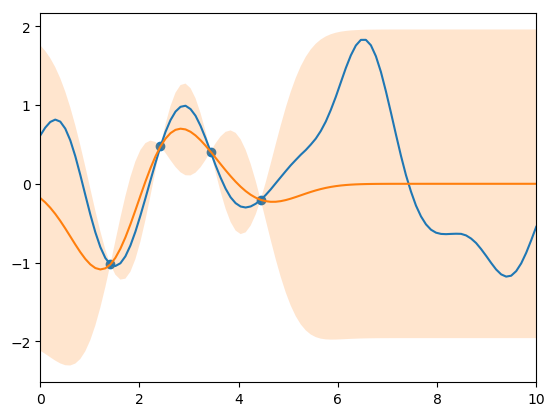

In [14]:
# create random "true" function
X = range(0,stop=10,length=100)'
Y = sampleGP(X, zeroMean(), squaredExponential())
plot(dropdims(X,dims=1), Y)
xlim(0,10)

# create training set
trainIndex = [15, 25, 35, 45]
Xtrain = X[:,trainIndex]
Ytrain = Y[trainIndex]
scatter(Xtrain, Ytrain)

# predict
(μ, σ) = predict(Xtrain, Ytrain, X, squaredExponential(1))
plot(dropdims(X,dims=1), μ)
upperConfidence = μ .+ 1.96 * σ
lowerConfidence = μ .- 1.96 * σ
fill_between(dropdims(X,dims=1), upperConfidence, lowerConfidence, alpha="0.2");

What if we want to have noise?

In [15]:
# assume y = f(x) + eps where eps ~ N(0,sigma^2)
function predict(Xtrain, Ytrain, Xpred, k::Function, sigma::Real = 0)
    K = (X, Y) -> covMatrix(X, Y, k)
    tmp = K(Xpred, Xtrain) * inv(K(Xtrain, Xtrain) + sigma^2 * I)
    mu = tmp * Ytrain
    S = K(Xpred, Xpred) - tmp * K(Xtrain, Xpred)
    sd = sqrt.(diag(S) .+ eps())
    mu, sd
end;

In [16]:
function plotPredict(Xtrain, Ytrain, X, k, sigma::Real = 0)
    (mu, sd) = predict(Xtrain, Ytrain, X, k, sigma)
    plot(dropdims(X,dims=1), mu)
    upperConfidence = mu .+ 1.96 * sd
    lowerConfidence = mu .- 1.96 * sd
    fill_between(dropdims(X,dims=1), upperConfidence, lowerConfidence, alpha="0.2");    
    mu, sd
end;

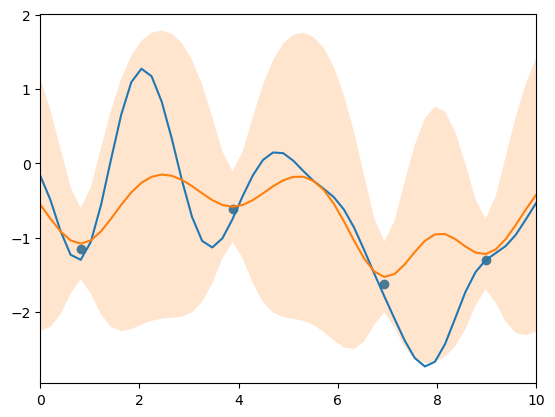

In [17]:
# noise parameter
sigmaNoise = 0.25

# create random "true" function
X = range(0,stop=10,length=50)'
Y = sampleGP(X, zeroMean(), squaredExponential())
plot(dropdims(X,dims=1), Y)
xlim(0,10)

# create training set
trainIndex = [5, 20, 35, 45]
Xtrain = X[:,trainIndex]
Ytrain = Y[trainIndex] + randn(length(trainIndex)) * sigmaNoise
scatter(Xtrain, Ytrain)

# predict
plotPredict(Xtrain, Ytrain, X, squaredExponential(), sigmaNoise);

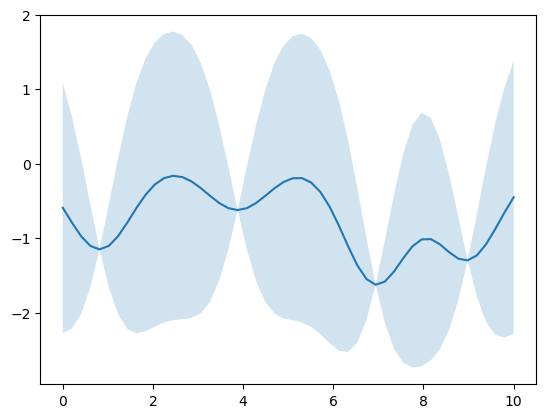

In [18]:
plotPredict(Xtrain, Ytrain, X, squaredExponential(), 0);

# Prediction-Based Optimization

In [19]:
function PyPlot.plot(f, lo, hi)
    x = range(lo, stop=hi, length=100)
    plot(x, f.(x))
end

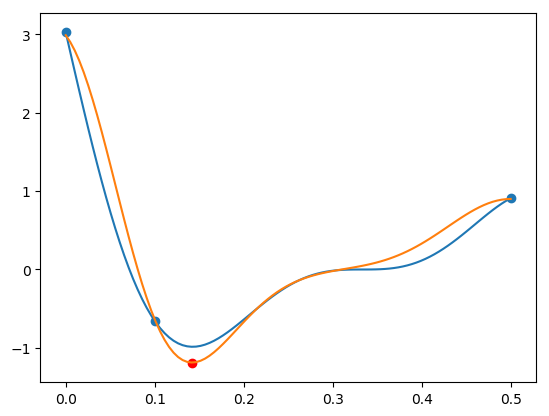

In [20]:
# Example from EDSM Sec. 3.2.1
f(x) = (6x - 2)^2 * sin(12x - 4)
plot(f, 0, 0.5);
# generate training data
Xtrain = [0 0.1 0.5]
Ytrain = dropdims(map(f, Xtrain), dims=1)
scatter(Xtrain, Ytrain)
# predict
Xpred = range(0,stop=0.5,length=100)'
(mu, sd) = predict(Xtrain, Ytrain, Xpred, squaredExponential(0.1), 1e-1)
plot(Xpred', mu);
# find minimum
i = argmin(mu)
scatter(Xpred[i], mu[i], color = "red");

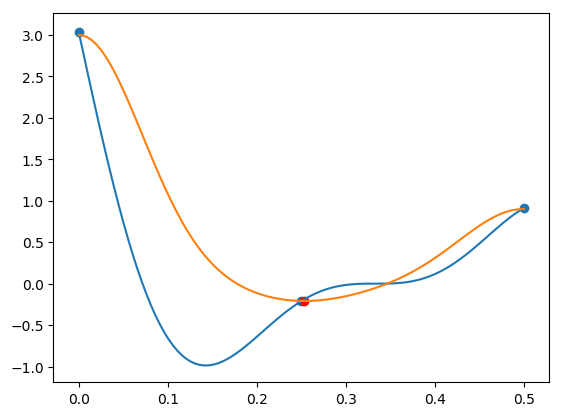

In [21]:
# Example from EDSM Sec. 3.2.1
f(x) = (6x - 2)^2 * sin(12x - 4)
plot(f, 0, 0.5);
# generate training data
Xtrain = [0 0.25 0.5]
Ytrain = dropdims(map(f, Xtrain), dims=1)
scatter(Xtrain, Ytrain)
# predict
Xpred = range(0,stop=0.5,length=100)'
(mu, sd) = predict(Xtrain, Ytrain, Xpred, squaredExponential(0.1), 1e-1)
plot(Xpred', mu);
# find minimum
i = argmin(mu)
scatter(Xpred[i], mu[i], color = "red");

Clearly, using the mean prediction to select the next point does not always work

# Error-Based Exploration

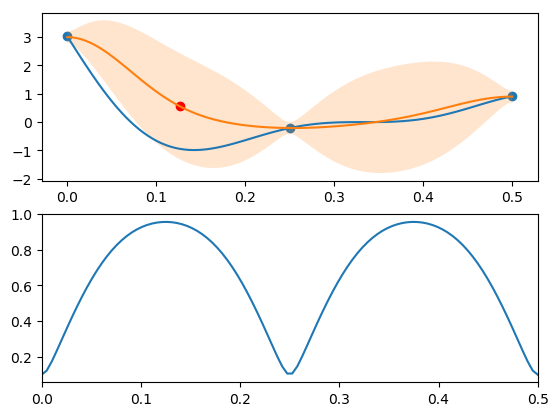

In [22]:
subplot(2,1,1)
f(x) = (6x - 2)^2 * sin(12x - 4)
plot(f, 0, 0.5);
# generate training data
Xtrain = [0 0.25 0.5]
Ytrain = dropdims(map(f, Xtrain), dims=1)
scatter(Xtrain, Ytrain)
# predict
Xpred = range(0,stop=0.5,length=100)'
(mu, sd) = plotPredict(Xtrain, Ytrain, Xpred, squaredExponential(0.1), 1e-1)
# find minimum
i = argmax(sd)
scatter(Xpred[i], mu[i], color = "red");

# plot sd
subplot(2,1,2)
plot(Xpred', sd)
xlim(0,0.5);

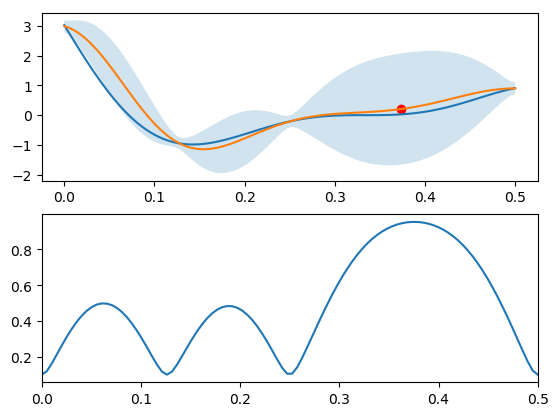

In [23]:
subplot(2,1,1)
plot(f,0,0.5)
Xtrain = hcat(Xtrain, Xpred[i]) # add point to training set
Ytrain = dropdims(map(f, Xtrain), dims=1)
# predict
(mu, sd) = plotPredict(Xtrain, Ytrain, Xpred, squaredExponential(0.1), 1e-1)
# find minimum
i = argmax(sd)
scatter(Xpred[i], mu[i], color = "red");

# plot sd
subplot(2,1,2)
plot(Xpred', sd)
xlim(0,0.5);

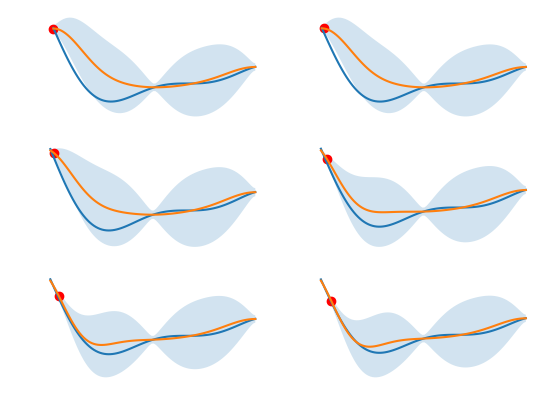

In [24]:
Xtrain = [0 0.25 0.5]
for i = 1:6
    Ytrain = dropdims(map(f, Xtrain), dims=1)
    subplot(3,2,i)
    plot(f,0,0.5)
    (mu, sd) = plotPredict(Xtrain, Ytrain, Xpred, squaredExponential(0.1), 1e-1)
    #i = argmax(sd)
    scatter(Xpred[i], mu[i], color = "red")
    Xtrain = hcat(Xtrain, Xpred[i]) # add point to training set
    axis("off")
end

# Statistical Lower Bound Exploration

$LB(x) = \hat y(s) - A\hat s(x)$  
where $A$ is the a constant that controls the exploration / exploitation balance (using notation from EDSM p. 86).  
What are the properties as $A \rightarrow 0$ and $A \rightarrow \infty$?

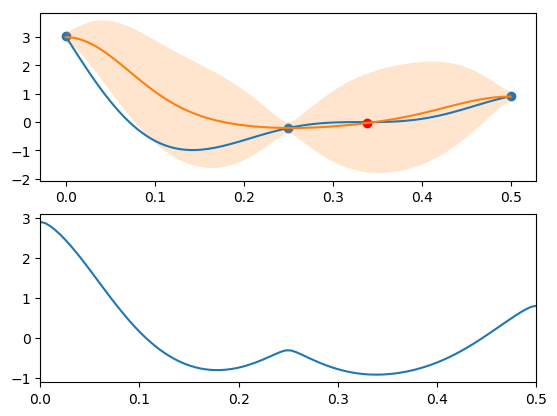

In [25]:
A = 1

subplot(2,1,1)
f(x) = (6x - 2)^2 * sin(12x - 4)
plot(f,0,0.5);
# generate training data
Xtrain = [0 0.25 0.5]
Ytrain = dropdims(map(f, Xtrain), dims=1)
scatter(Xtrain, Ytrain)
# predict
Xpred = range(0,stop=0.5,length=100)'
(mu, sd) = plotPredict(Xtrain, Ytrain, Xpred, squaredExponential(0.1), 1e-1)
# find minimum
i = argmin(mu - A * sd)
scatter(Xpred[i], mu[i], color = "red");

# plot mu + A * sd
subplot(2,1,2)
plot(Xpred', mu - A * sd)
xlim(0,0.5);

# Probability of Improvement

Probability of improvement:
$$\Phi\left( \frac{y_{min} - \hat y(x)}{\hat s(x)} \right) = \frac12 + \frac12 \text{erf}\left( \frac{y_{min} - \hat y(x)}{\sqrt{2} \hat s(x)} \right)$$
(see EDSM p. 88)

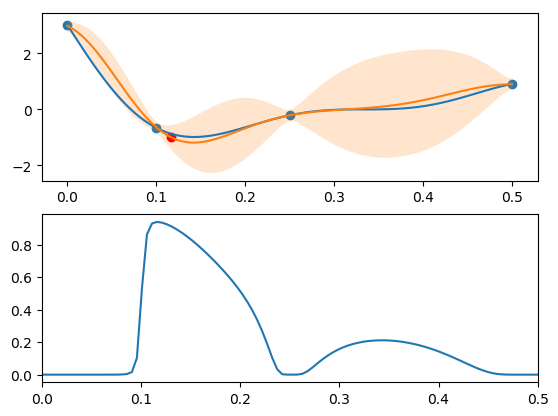

In [26]:
using SpecialFunctions
A = 1

subplot(2,1,1)
f(x) = (6x - 2)^2 * sin(12x - 4)
plot(f,0,0.5);
# generate training data
Xtrain = [0 0.1 0.25 0.5]
Ytrain = dropdims(map(f, Xtrain), dims=1)
scatter(Xtrain, Ytrain)
# predict
Xpred = range(0,stop=0.5,length=100)'
(mu, sd) = plotPredict(Xtrain, Ytrain, Xpred, squaredExponential(0.1), 1e-1)
# find minimum
ymin = minimum(Ytrain)
probImprovement = 0.5 .+ 0.5 * erf.((ymin .- mu)./(sqrt(2)*sd))
i = argmax(probImprovement)
scatter(Xpred[i], mu[i], color = "red");

# plot mu + A * sd
subplot(2,1,2)
plot(Xpred', probImprovement)
xlim(0,0.5);

# Expected Improvement

$E[\max\{y_{min} - Y, 0\}] = (y_{min} - \hat y(x)) \Phi\left( \frac{y_{min} - \hat y(x)}{\hat s(x)} \right) + \hat s(x) \phi\left( \frac{y_{min} - \hat y(x)}{\hat s(x)} \right)$

In [27]:
Phi(x) = 0.5 .+ 0.5 * erf.(x ./ sqrt(2))
phi(x) = exp.(-0.5 * x.^2) / sqrt(2 * pi);

In [28]:
function expectedImprovement(ymin, mu, sd)
    tmp = (ymin .- mu)./sd
    (ymin .- mu) .* Phi(tmp) + sd .* phi(tmp)
end;

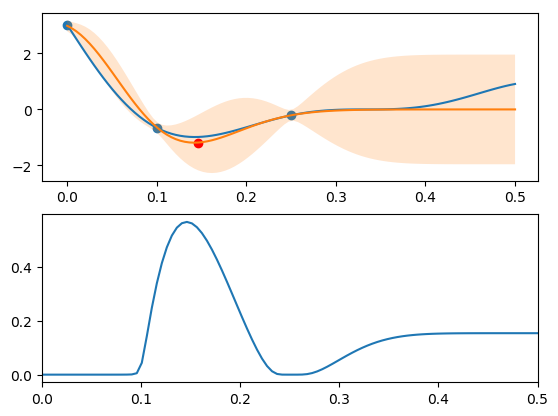

In [29]:
A = 1

subplot(2,1,1)
f(x) = (6x - 2)^2 * sin(12x - 4)
plot(f,0,0.5);
# generate training data
Xtrain = [0 0.1 0.25]
Ytrain = dropdims(map(f, Xtrain), dims=1)
scatter(Xtrain, Ytrain)
# predict
Xpred = range(0,stop=0.5,length=100)'
(mu, sd) = plotPredict(Xtrain, Ytrain, Xpred, squaredExponential(0.1), 1e-1)
# find minimum
ymin = minimum(Ytrain)
expImprovement = expectedImprovement(ymin, mu, sd)
i = argmax(expImprovement)
scatter(Xpred[i], mu[i], color = "red");

# plot mu + A * sd
subplot(2,1,2)
plot(Xpred', expImprovement)
xlim(0,0.5);